In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.MirroredStrategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

MIXED_PRECISION = True
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
REPLICAS:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 with Max-Q Design, compute capability 7.5
Mixed precision enabled


In [5]:
import librosa
import os

In [6]:
test_path = r"C:\Users\bapti\KTH\clip_wav\test"
valid_path = r"C:\Users\bapti\KTH\clip_wav\validation"
train_path = r"C:\Users\bapti\KTH\clip_wav\train"

labels_path = r"C:\Users\bapti\KTH\PodcastFillers.csv"
checkpoint_filepath = r"C:\Users\bapti\KTH\checkpoints\checkpoint"

In [7]:
sampling_rate = 44.1*1e3
lifter = 22
n_fft = 512
win_length = 400
hop_length = 200


In [8]:
test_files = os.listdir(path = test_path)
train_files = os.listdir(path =  train_path)
valid_files = os.listdir(path =  valid_path)

In [9]:
df_labels = pd.read_csv(labels_path)
df_labels.head()

,clip_name,pfID,label_full_vocab,label_consolidated_vocab,podcast_filename,event_start_inepisode,event_end_inepisode,event_start_inclip,event_end_inclip,clip_start_inepisode,clip_end_inepisode,duration,confidence,n_annotators,episode_split_subset,clip_split_subset,pitch_cent
0,00000.wav,0,Agree,None,The Voice of 5G_Episode 12_5G & IoT,1592.770048,1593.129984,0.320032,0.679968,1592.450016,1593.450016,0.359936,1.0,2,train,extra,2335.659222
1,00001.wav,1,Music,Music,UX Podcast_#198 Connected content with Carrie ...,2231.030000,2231.420000,0.305000,0.695000,2230.725000,2231.725000,0.390000,1.0,2,train,train,1466.040477
2,00002.wav,2,Uh,Uh,Education_Ep 1 - Handmade Dev Show 2017,1271.340000,1271.790080,0.274960,0.725040,1271.065040,1272.065040,0.450080,1.0,2,validation,validation,1249.172108
3,00003.wav,3,Breath,Breath,Design Story_025 Moira Cullen Design is Soft P...,2608.590029,2608.770000,0.410014,0.589986,2608.180014,2609.180014,0.179971,1.0,2,test,test,6181.648929
4,00004.wav,4,Music,Music,The Come Up Show_Lizzo shares stories about he...,1139.150029,1139.410000,0.370014,0.629986,1138.780014,1139.780014,0.259971,1.0,3,train,train,3465.520202


In [10]:
df_labels = df_labels[["clip_name","label_full_vocab", "confidence", "clip_split_subset"]]

In [11]:
df_labels.head()

,clip_name,label_full_vocab,confidence,clip_split_subset
0,00000.wav,Agree,1.0,extra
1,00001.wav,Music,1.0,train
2,00002.wav,Uh,1.0,validation
3,00003.wav,Breath,1.0,test
4,00004.wav,Music,1.0,train


In [12]:
#x_test = df_labels[df_labels["clip_split_subset"]=="test"]["clip_name"].apply(lambda x : librosa.load(test_path+"/"+x))

In [13]:
y_test = df_labels[df_labels["clip_split_subset"]=="test"]["label_full_vocab"]

In [14]:
y_test.unique().shape

(7,)

In [15]:
from keras.utils.np_utils import to_categorical   
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
target = oe.fit_transform(y_test.values.reshape(-1, 1)).ravel()
categorical_labels = to_categorical(target, num_classes=7)

In [16]:
def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

In [17]:
test_file = test_files[0]
audio, sampling_rate = librosa.load(test_path+"/"+test_file )
mel_spectrogram = librosa.feature.melspectrogram(y=audio,
                                                     sr=sampling_rate,
                                                     n_mels=40,
                                                     hop_length=128,
                                                     fmax=None)

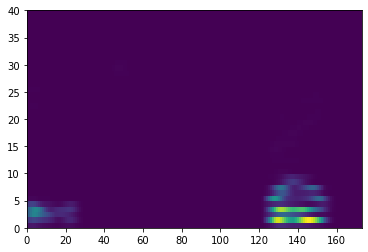

In [18]:
plt.pcolormesh(mel_spectrogram)

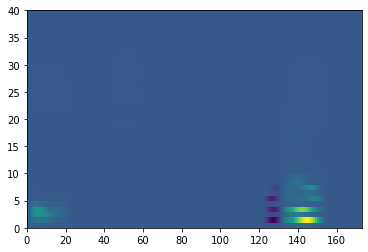

In [19]:
plt.pcolormesh(lifter(mel_spectrogram))

In [20]:
a = np.array([i for i in range(10)])

In [21]:
def mv_avg(tab, size_left = 3, size_right = 3):
    new_tab = np.zeros(tab.shape)
    for i in range(len(tab)):
        if  i<= size_left :
            new_tab[i] = tab[0:i+size_right].sum()/(size_left+size_right)
#             print(tab[0:i+size_right])
        elif i >= len(tab)-1-size_right :
            new_tab[i] = tab[i-size_left+1:].sum()/(size_left+size_right)
#             print(tab[i-size_left+1:])
        else :
            new_tab[i] = tab[i-size_left:i+size_right].sum()/(size_left+size_right)
#             print(tab[i-size_left:i+size_right])
    return new_tab

In [22]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
mv_avg(a)

array([0.5       , 1.        , 1.66666667, 2.5       , 3.5       ,
       4.5       , 6.5       , 5.83333333, 5.        , 4.        ])

In [66]:
def lecture(name_path, labels_path = labels_path,n_mels=40, size_avg = 10):
    df_labels = pd.read_csv(labels_path)[["clip_name","label_full_vocab", "confidence", "clip_split_subset"]]
    y_test = df_labels[df_labels["clip_split_subset"]=="test"]["label_full_vocab"]
    x_test = df_labels[df_labels["clip_split_subset"]=="test"]["clip_name"].apply(lambda x : librosa.load(test_path+"/"+x)).apply(lambda x : lifter(librosa.feature.melspectrogram(y=x[0],
                                                                                                                                                                                   sr=sampling_rate,
                                                                                                                                                                                   n_mels=n_mels,
                                                                                                                                                                                   hop_length=128,
                                                                                                                                                                                   fmax=None)))
    
    return x_test, y_test

def transfo(x_test, y_test,n_mels=40, size_avg = 10):
    target = oe.fit_transform(y_test.values.reshape(-1, 1)).ravel()
    y_test = to_categorical(target, num_classes=7)
#     len_max= 173 
    len_max = 0
    x_test_mel  = x_test.values
#     x_test_avg =  np.array([mv_avg(i.values,size_left = size_avg, size_right = size_avg) for i in x_test.values])
    for i in x_test_mel :
        len_max = max(len_max, i.shape[1])
    x_test_mel_zero_padding = np.zeros((x_test_mel.shape[0],len_max,n_mels), dtype = "float16").astype("float16")
#     x_test_mel_zero_padding_avg = np.zeros((x_test_mel.shape[0],len_max,n_mels))
    print()
    print()
    for i in range(x_test_mel.shape[0]) :
        for j in range(len_max):
            for k in range(n_mels):
#                 print("limits :", len(x_test_mel),x_test_mel[i].shape[0],len_max)
#                 print("values :", i,j,k)
#                 print("desired shape",x_test_mel_zero_padding[i].shape)
#                 print("objet shape",x_test_mel[i].T.shape)
                try : 
                    a = x_test_mel[i].T[j,k].astype("float16")
                    x_test_mel_zero_padding[i,j,k] =  a
                except :
                    print("limits :", len(x_test_mel),x_test_mel[i].shape[0],len_max)
                    print("values :", i,j,k)
                    print("desired shape",x_test_mel_zero_padding[i].shape)
                    print("objet shape",x_test_mel[i].T.shape)
                
#     x_test_mel_zero_padding = np.concatenate((x_test_mel_zero_padding,x_test_mel_zero_padding_avg), axis = 2)
    #y_test_reformed = np.zeros((y_test.shape[0], 155, y_test.shape[1]))
    #for i in range(y_test.shape[0]):
    #    for j in range(y_test.shape[1]):
    #        for k in range(155):
    #            y_test_reformed[i,k,j] = y_test[i,j]

    #return x_test_mel_zero_padding, y_test_reformed
    
    return x_test_mel_zero_padding, y_test

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
batch_size = 200

lr_min = 1e-5
lr_max = 1e-2

def my_cosine_decay(epoch,
                    epoch_max=5,
                    LR_START = 0.0001/2,
                    LR_MAX =  lr_max,
                    LR_MIN = lr_min,
                    LR_RAMPUP_EPOCHS = 3,
                    LR_SUSTAIN_EPOCHS = 0,
                    LR_ALPHA_DECAY = .7
                   ):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        cosine_decay=max(0.5*(1+np.cos(np.pi*((epoch-LR_RAMPUP_EPOCHS)/epoch_max))),LR_MIN)
        decayed=(1-LR_ALPHA_DECAY)*cosine_decay+LR_ALPHA_DECAY
        learning_rate=LR_MAX*decayed
    return learning_rate

def lr_decay(epoch,
            LR_START = lr_max/2,
            LR_MAX =  lr_max,
            LR_MIN = lr_min,
            LR_RAMPUP_EPOCHS = 3,
            LR_SUSTAIN_EPOCHS = 0,
            LR_ALPHA_DECAY = .05
                   ):
    learning_rate=max(LR_MAX*np.exp(-LR_ALPHA_DECAY*epoch), LR_MIN)
    return learning_rate
   

def my_clr(epoch,
           epoch_cycle = 8,
           LR_MIN = lr_min,
           LR_MAX = lr_max,
           LR_ALPHA_DECAY = .9):
    nb_cycle = epoch // epoch_cycle
    k=0
    while k < nb_cycle :
        LR_MAX = (LR_MAX+ LR_MIN)*LR_ALPHA_DECAY
        k += 1
    if epoch % epoch_cycle < epoch_cycle//2 :
        learning_rate = (LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MIN
    else :
        learning_rate = -(LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MAX
    return learning_rate
    
lrfn=lambda epoch : my_clr(
       epoch,
        LR_MIN = lr_min,
        LR_MAX = lr_max
    )
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
early_stopper = EarlyStopping(monitor='val_loss',patience=24,verbose=1)


In [26]:
x_train, y_train = lecture(train_path,n_mels=60)
x_valid, y_valid = lecture(valid_path,n_mels=60)
x_test, y_test = lecture(test_path,n_mels=60)

In [27]:
# x_train = pd.DataFrame(np.load("x_train_256.npy",allow_pickle=True))
# x_valid = pd.DataFrame(np.load("x_valid_256.npy",allow_pickle=True))
# x_test = pd.DataFrame(np.load("x_test_256.npy",allow_pickle=True))

In [28]:
# y_train = pd.DataFrame(np.load("y_train.npy",allow_pickle=True))
# y_valid = pd.DataFrame(np.load("y_valid.npy",allow_pickle=True))
# y_test = pd.DataFrame(np.load("y_test.npy",allow_pickle=True))

In [29]:
# np.save("train", x_train.values)
# np.save("valid", x_valid.values)
# np.save("test", x_test.values)

In [30]:
# np.save("y_train", y_train.values)
# np.save("y_valid", y_valid.values)
# np.save("y_test", ry_test.values)

In [ ]:
x_train_b, y_train_b = transfo(x_train, y_train,n_mels=60)
x_valid_b, y_val_b = transfo(x_valid, y_valid,n_mels=60)
x_test_b, y_test_b = transfo(x_test, y_test,n_mels=60)



limits : 9475 60 173
values : 561 132 0
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 1
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 2
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 3
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 4
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 5
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 6
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 7
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 8
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 9
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 10
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 132 11
desired sh

values : 561 133 40
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 41
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 42
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 43
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 44
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 46
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 47
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 48
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 49
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 50
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 133 51
desired shape (173, 60)

limits : 9475 60 173
values : 561 135 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 46
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 47
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 48
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 49
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 50
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 51
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 52
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 53
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 54
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 55
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 135 56
de

values : 561 138 35
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 36
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 37
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 38
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 39
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 40
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 41
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 42
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 43
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 44
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 138 46
desired shape (173, 60)

limits : 9475 60 173
values : 561 140 16
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 17
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 18
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 19
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 20
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 21
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 22
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 23
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 24
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 25
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 26
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 140 27
de

limits : 9475 60 173
values : 561 142 0
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 1
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 2
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 3
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 4
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 5
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 6
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 7
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 8
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 9
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 10
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 142 11
desired shap

limits : 9475 60 173
values : 561 144 5
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 6
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 7
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 8
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 9
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 10
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 11
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 12
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 13
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 14
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 15
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 144 16
desired

values : 561 146 42
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 43
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 44
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 46
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 47
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 48
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 49
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 50
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 51
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 52
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 146 53
desired shape (173, 60)

desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 148 57
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 148 58
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 148 59
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 0
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 1
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 2
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 3
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 4
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 5
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 6
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 149 7
desired shape (173, 60)
objet shape (132, 60)
limit

limits : 9475 60 173
values : 561 151 43
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 44
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 46
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 47
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 48
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 49
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 50
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 51
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 52
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 53
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 151 54
de

objet shape (132, 60)
limits : 9475 60 173
values : 561 154 30
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 31
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 32
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 33
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 34
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 35
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 36
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 37
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 38
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 39
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 154 40
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173


values : 561 157 16
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 17
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 18
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 19
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 20
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 21
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 22
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 23
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 24
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 25
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 26
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 157 27
desired shape (173, 60)

limits : 9475 60 173
values : 561 160 3
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 4
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 5
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 6
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 7
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 8
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 9
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 10
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 11
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 12
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 13
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 160 14
desired s

desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 50
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 51
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 52
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 53
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 54
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 55
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 56
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 57
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 58
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 162 59
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 163 0
desired shape (173, 60)
objet shape (132, 60

values : 561 165 36
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 37
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 38
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 39
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 40
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 41
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 42
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 43
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 44
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 45
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 46
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 165 47
desired shape (173, 60)

values : 561 168 26
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 27
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 28
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 29
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 30
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 31
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 32
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 33
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 34
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 35
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 36
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 168 37
desired shape (173, 60)

desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 10
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 11
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 12
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 13
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 14
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 15
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 16
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 17
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 18
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 19
desired shape (173, 60)
objet shape (132, 60)
limits : 9475 60 173
values : 561 171 20
desired shape (173, 60)
objet shape (132, 6

limits : 9475 60 173
values : 6432 118 0
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 1
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 5
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 6
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 7
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 8
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 9
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 10
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 118 11


objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 38
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 39
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 40
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 41
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 42
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 43
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 44
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 45
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 46
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 47
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 119 48
desired shape (173, 60)
objet shape (118, 60)
limits : 9

objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 43
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 44
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 45
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 46
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 47
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 48
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 49
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 50
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 51
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 52
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 121 53
desired shape (173, 60)
objet shape (118, 60)
limits : 9

limits : 9475 60 173
values : 6432 125 11
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 12
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 13
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 14
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 20
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 125 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

limits : 9475 60 173
values : 6432 127 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 20
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 23
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 24
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 25
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 127 26
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

limits : 9475 60 173
values : 6432 129 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 23
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 24
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 25
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 26
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 27
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 28
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 29
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 30
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 129 31
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 26
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 27
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 28
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 29
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 30
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 31
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 32
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 33
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 34
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 35
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 131 36
desired shape (173, 60)
objet shape (118, 60)
limits : 9

objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 31
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 32
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 33
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 34
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 35
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 36
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 37
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 38
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 39
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 40
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 133 41
desired shape (173, 60)
objet shape (118, 60)
limits : 9

limits : 9475 60 173
values : 6432 136 13
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 14
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 20
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 136 23
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

values : 6432 138 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 23
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 24
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 25
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 26
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 27
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 28
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 29
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 30
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 31
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 32
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 138 33
desired sha

limits : 9475 60 173
values : 6432 141 9
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 10
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 11
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 12
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 13
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 14
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 141 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 643

desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 143 56
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 143 57
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 143 58
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 143 59
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 0
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 1
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 5
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 144 6
desired shape (173, 60)
objet shape (11

values : 6432 146 42
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 43
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 44
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 45
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 46
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 47
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 48
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 49
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 50
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 51
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 52
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 146 53
desired sha

limits : 9475 60 173
values : 6432 149 29
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 30
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 31
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 32
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 33
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 34
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 35
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 36
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 37
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 38
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 149 39
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

values : 6432 152 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 20
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 23
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 24
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 25
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 152 26
desired sha

limits : 9475 60 173
values : 6432 155 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 5
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 6
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 7
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 8
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 9
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 10
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 11
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 12
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 155 1

desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 13
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 14
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 19
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 20
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 21
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 22
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 158 23
desired shape (173, 60)
objet sh

objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 54
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 55
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 56
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 57
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 58
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 159 59
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 160 0
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 160 1
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 160 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 160 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 160 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 6

values : 6432 162 55
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 162 56
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 162 57
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 162 58
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 162 59
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 0
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 1
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 5
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 163 6
desired shape (173

desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 9
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 10
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 11
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 12
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 13
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 14
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 15
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 16
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 17
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 18
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 166 19
desired shape (173, 60)
objet sha

values : 6432 168 55
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 168 56
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 168 57
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 168 58
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 168 59
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 0
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 1
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 2
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 3
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 4
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 5
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 169 6
desired shape (173

limits : 9475 60 173
values : 6432 171 42
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 43
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 44
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 45
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 46
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 47
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 48
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 49
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 50
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 51
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 6432 171 52
desired shape (173, 60)
objet shape (118, 60)
limits : 9475 60 173
values : 64

values : 6466 170 8
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 9
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 10
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 11
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 12
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 13
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 14
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 15
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 16
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 17
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 18
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 170 19
desired shape

limits : 9475 60 173
values : 6466 172 46
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 47
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 48
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 49
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 50
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 51
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 52
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 53
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 54
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 55
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 6466 172 56
desired shape (173, 60)
objet shape (167, 60)
limits : 9475 60 173
values : 64

limits : 9475 60 173
values : 6689 151 57
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 151 58
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 151 59
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 0
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 1
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 2
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 3
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 4
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 5
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 6
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 7
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 152 8

limits : 9475 60 173
values : 6689 154 30
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 31
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 32
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 33
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 34
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 35
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 36
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 37
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 38
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 39
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 154 40
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 66

limits : 9475 60 173
values : 6689 157 41
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 42
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 43
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 44
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 45
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 46
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 47
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 48
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 49
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 50
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 157 51
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 66

values : 6689 159 21
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 22
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 23
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 24
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 25
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 26
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 27
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 28
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 29
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 30
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 31
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 159 32
desired sha

values : 6689 161 1
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 2
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 3
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 4
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 5
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 6
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 7
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 8
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 9
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 10
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 11
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 161 12
desired shape (173, 

values : 6689 163 11
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 12
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 13
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 14
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 15
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 16
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 17
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 18
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 19
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 20
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 21
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 163 22
desired sha

values : 6689 165 36
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 37
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 38
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 39
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 40
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 41
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 42
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 43
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 44
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 45
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 46
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 165 47
desired sha

limits : 9475 60 173
values : 6689 168 23
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 24
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 25
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 26
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 27
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 28
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 29
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 30
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 31
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 32
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 168 33
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 66

desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 10
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 11
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 12
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 13
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 14
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 15
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 16
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 17
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 18
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 19
desired shape (173, 60)
objet shape (150, 60)
limits : 9475 60 173
values : 6689 171 20
desired shape (173, 60)
objet sh

limits : 9475 60 173
values : 7261 165 0
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 1
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 2
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 3
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 4
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 5
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 6
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 7
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 8
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 9
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 10
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 165 11


objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 38
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 39
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 40
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 41
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 42
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 43
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 44
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 45
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 46
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 47
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 166 48
desired shape (173, 60)
objet shape (165, 60)
limits : 9

objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 43
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 44
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 45
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 46
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 47
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 48
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 49
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 50
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 51
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 52
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 168 53
desired shape (173, 60)
objet shape (165, 60)
limits : 9

limits : 9475 60 173
values : 7261 172 11
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 12
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 13
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 14
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 15
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 16
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 17
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 18
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 19
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 20
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 7261 172 21
desired shape (173, 60)
objet shape (165, 60)
limits : 9475 60 173
values : 72

limits : 9475 60 173
values : 8472 136 16
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 17
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 18
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 19
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 20
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 21
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 23
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 24
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 25
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 136 26
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 84

objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 21
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 23
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 24
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 25
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 26
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 27
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 28
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 29
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 30
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 138 31
desired shape (173, 60)
objet shape (135, 60)
limits : 9

values : 8472 141 12
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 13
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 14
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 15
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 16
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 17
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 18
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 19
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 20
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 21
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 141 23
desired sha

values : 8472 143 12
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 13
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 14
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 15
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 16
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 17
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 18
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 19
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 20
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 21
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 143 23
desired sha

values : 8472 145 17
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 18
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 19
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 20
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 21
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 23
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 24
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 25
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 26
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 27
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 145 28
desired sha

values : 8472 147 22
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 23
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 24
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 25
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 26
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 27
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 28
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 29
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 30
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 31
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 32
desired shape (173, 60)
objet shape (135, 60)
limits : 9475 60 173
values : 8472 147 33
desired sha

In [ ]:
#x_test_mel_zero_padding = (x_test_mel_zero_padding-x_test_mel_zero_padding.mean(axis= 1))/np.sqrt(np.mean(abs(x_test_mel_zero_padding-x_test_mel_zero_padding.mean(axis = 1))))**2

In [ ]:
x_train.shape 

In [ ]:
x_train_m = x_train.mean(axis = 0)
x_train_norm = (x_train-x_train_m)/np.sqrt(np.mean(abs(x_train-x_train_m)))**2
x_valid_m = x_valid.mean(axis = 0)
x_valid_norm = (x_valid-x_valid_m)/np.sqrt(np.mean(abs(x_valid-x_valid_m)))**2
x_test_m = x_test.mean(axis = 0)
x_test_norm = (x_test-x_test_m)/np.sqrt(np.mean(abs(x_test-x_test_m)))**2

In [ ]:
x_train_norm.shape

In [ ]:
def create_model(dropout = 0.4, nb_conv_layer = 2, nb_lstm_layers = 2, size_input = 40):
    
    input_layer = tf.keras.layers.Input(shape = (173,size_input))
    first_layer = tf.keras.layers.Conv1D(filters = size_input,kernel_size = (10),activation="relu")(input_layer)
    first_layer = tf.keras.layers.Reshape((173-9,size_input))(first_layer)
    first_layer = tf.keras.layers.BatchNormalization()(first_layer)
    first_layer = tf.keras.layers.Conv1D(filters = size_input,kernel_size = (10),activation="relu")(first_layer)
    first_layer = tf.keras.layers.Reshape((173-18,size_input))(first_layer)
    first_layer = tf.keras.layers.BatchNormalization()(first_layer)
    
    second_layer = tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(128,return_sequences=True, dropout = dropout),
                                                 backward_layer=tf.keras.layers.LSTM(128, go_backwards=True,return_sequences=True, dropout = dropout))(first_layer)
    second_layer = tf.keras.layers.BatchNormalization()(second_layer)
    second_layer = tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(128,return_sequences=False, dropout = dropout),
                                                 backward_layer=tf.keras.layers.LSTM(128, go_backwards=True,return_sequences=False, dropout = dropout))(second_layer)
    second_layer = tf.keras.layers.BatchNormalization()(second_layer)
    #last_layer  = tf.keras.layers.Dense(1)(second_layer)
   #output = tf.keras.layers.Dense(7,activation = None, dtype='float32')(last_layer)
    output = tf.keras.layers.Dense(7,activation = None, dtype='float32')(second_layer)
    output = tf.keras.layers.Dropout(dropout)(output)
    output = tf.keras.layers.Activation("softmax")(output)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs= output)
    model.compile(loss="categorical_crossentropy",metrics=["binary_crossentropy","accuracy"],optimizer = "RMSprop")
    return model

In [ ]:
Teacher_model = create_model()

checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# lrfn=lambda epoch : my_cosine_decay(
#        epoch,
#         LR_MIN = lr_min,
#         LR_MAX = lr_max
#     )

history = Teacher_model.fit(x_train_norm , y_train,
                            validation_data=(x_valid_norm,y_valid), 
                            batch_size = 200, epochs=100,  callbacks = [lr_callback,model_checkpoint_callback])

In [ ]:
plt.plot(np.arange(1,len(history.history["loss"]) + 1),history.history["loss"], color="blue")
plt.plot(np.arange(1,len(history.history["val_loss"]) + 1),history.history["val_loss"], color="orange")
plt.show()

In [ ]:
Teacher_model.evaluate(x = x_test, y =  y_test)